# Régression logistique

On introduit ici la régression logistique, bien que ce soit plutôt un problème de classification. Néanmoins, son extrême proximité avec les problèmes de régression (qui lui doivent son nom) en font une excellente généralisation du problème de la régression linéaire aux problèmes non-linéaires, et nous permettent d'introduire les concepts de descente de gradient (éventuellement stochastique) dans un cas très facilement contrôlable.

## Notions abordées dans cette note

 - Faire le lien entre régression et classification dans un cas simple (et historique)
 - Comprendre la notion de non-linéarité du modèle statistique
 - Comprendre la notion de descente de gradient
 - Comprendre la généralisation à tous les problèmes de machine-learning

Le module [regression](regression.py) est associé à cette note.

## Régression logistique

On a vu [dans le chapitre précédent](linear_regression) que l'on pouvait générer autant de features que l'on voulait au sein d'une matrice $\mathbf{X}$ représentant les données. Cette matrice pouvait alors s'insérer dans un modèle de régression linéaire sans difficulté. On va maintenant généraliser une dernière fois la régression linéaire, et mettre les paramètres du modèle $\boldsymbol{\alpha}$ et les données $\mathbf{X}$ dans une fonction non-linéaire ? Par exemple, on peut prendre pour modèle
 
$$
\mathbf{y}=\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)
$$

avec $\Phi$ n'importe quelle fonction (en pratique une bijection). Dans le cas de la régression logistique, la fonction en question est la [fonction logistique](https://en.wikipedia.org/wiki/Logistic_function)
 
$$
\Phi\left(x\right)=\frac{1}{1+e^{-x}}
$$

qui est un exemple de [fonction sigmoïde](https://en.wikipedia.org/wiki/Sigmoid_function).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import regression

seed = 356
rng = np.random.default_rng(seed)

In [2]:
x = np.linspace(-5, 5, 65)
y1 = 1/(1+np.exp(-x))
y2 = 1/(1+np.exp(-2*x))

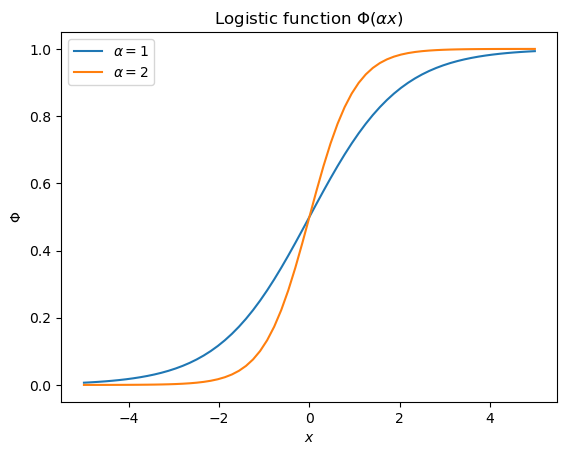

<Figure size 640x480 with 0 Axes>

In [3]:
plt.plot(x, y1, label=r"$\alpha = 1$")
plt.plot(x, y2, label=r"$\alpha = 2$")
plt.title(r"Logistic function $\Phi(\alpha x)$")
plt.xlabel("$x$")
plt.ylabel(r"$\Phi$")
plt.legend()
plt.show()
plt.clf()

Cette fonction tend vers $0$ en $x\rightarrow -\infty$ et vers $1$ en $+\infty$. La raideur du passage entre ces deux valeurs dépend du facteur $\alpha$ de $\Phi(\alpha x)$. C'est cette propriété qui permet d'espérer approcher les catégories $1$ ou $0$ à partir d'une fonction logistique. On est donc bien dans le cadre d'une régression : on va chercher à obtenir les paramètres $\boldsymbol{\alpha}$ comme dans le cas de la régression linéaire (voir ci-dessous un exemple de régression). Seulement cette fois, la fonction ressemble à un vote, que l'on peut catégoriser en deux classes : si $\Phi(x) < 0.5$ alors on attribuera la classe $0$ à la donnée $x$, sinon on attribuera la classe $1$ à la donnée.

### D'où vient la régression logistique ?

Faisons une rapide apparté sur l'origine de la régression logistique.

Soit une [loi de Bernouilli](https://en.wikipedia.org/wiki/Bernoulli_distribution) : cette loi représente la probabilité $p$ que la variable aléatoire $Y$ prennent la valeur $1$ ou la probabilité $1-p$ que $Y$ se réalise en $0$. La loi de probabilité de Bernouilli s'écrit

$$
\mathbb{P}\left(Y\right)=p^{y}\left(1-p\right)^{1-y}
$$

La fonction logistique $\mathrm{logit}$ s'exprime comme le logarithme du rapport de la probabilité d'une réussite sur la probabilité d'un échec (logarithme de la cote de l'évènement binaire)

$$
\mathrm{logit}\left(p\right)=\ln\frac{p}{1-p}\Rightarrow p=\frac{1}{1+e^{-\mathrm{logit}}}
$$
 
Si la fonction $\mathrm{logit}$ est supposé linéaire : $\mathrm{logit}=\mathbf{X}\cdot\boldsymbol{\alpha}$
et $p\rightarrow\Phi$ (attention, $\Phi$ est ici un vecteur de taille égale au nombre de lignes de la matrice $\mathbf{X}$), on obtient la fonction logistique dont l'argument est le modèe linéaire supposé

$$
\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)=\frac{1}{1+e^{-\mathbf{X}\cdot\boldsymbol{\alpha}}}
$$

C'est donc bien un modèle linéaire : on fait l'hypothèse que la fonction $\mathrm{logit}$ est linéaire pour pouvoir adapter les coefficients $\boldsymbol{\alpha}$ aux données collectées.

```{admonition} Quelques propriétés de la fonction logistique
:class: hint
On remarque par calcul direct que

$$
$1-\Phi\left(x\right)=\Phi\left(-x\right)$
$$

ce qui permet de renverser la loi de probabilité assez simplement (pour intervertir les états $0$ et $1$ notamment). 
La dérivée de la fonction logistique est remarquable, parce que non-linéaire : 

$$
\frac{d\Phi\left(z\right)}{d z} =\Phi\left(z\right)\left(1-\Phi\left(z\right)\right)
$$

La dérivée est d'ailleurs une autre définition de la fonction logistique, étudiée dans les [modèles de croissance en univers fini](https://en.wikipedia.org/wiki/Logistic_function#History), ou encore dans les modèles de propagation d'information.
```

###  Exemples de régressions logistiques

La régression logistique permet de modéliser des états discrets $\left\{ 0,1\right\} $
dépendants d'un ensemble de variables continues (non bornées en principe). Par exemple

 -  La survie d'un patient en fonction du temps : $y\in\left\{ \mathrm{mort}=0,\mathrm{vivant}=1\right\} $
vs. $t\in\left[0,+\infty\right[$
 -  La brisure d'une poutre en fonction de la longueur / du poids disposé à une de ses extrêmités : $y\in\left\{ \mathrm{cass\acute{e}}=0,\mathrm{resistant}=1\right\} $
vs. $L\in\left[0,+\infty\right[$ ou vs. $P\in\left[0,+\infty\right[$

Pour illustrer la régression logistique, générons tout d'abord des données d'entraînement. On génère aléatoirement des tirages de Bernouilli depuis la loi uniforme (par la méthode `numpy.random.random()`) en décallant cette loi uniforme de $p$, puis en attribuant la valeur $1$ aux données négatives une fois décalées, ou $0$ aux autres données.

In [4]:
size, p = 10, 0.2
bernouilli = [1 if rng.random() < p else 0 for _ in range(size)]
bernouilli

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]

On attribue maintenant ces variables aléatoire entre les valeurs $x=-5$ et $x=5$, pour un ensemble de points aléatoires, et lorsque la probabilité d'être dans l'état $0$ ou $1$ suit une distribution logistique de paramètre $\alpha = 2$.

In [5]:
size = 100  # nb of points
xmin, xmax = -5, 5
x = np.random.random(size)*(xmax-xmin) + xmin
p = 1 / (1 + np.exp(-2*x))
y = (1 - np.sign(rng.random(size) - p)) / 2

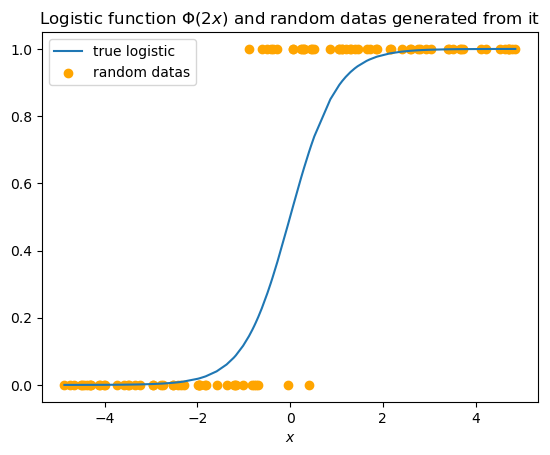

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(sorted(x), sorted(p), label="true logistic")
plt.scatter(x, y, color="orange", label="random datas")
plt.title(r"Logistic function $\Phi(2 x)$ and random datas generated from it")
plt.xlabel("$x$")
plt.legend()
plt.show()
plt.clf()

Dans ces données, on voit que les valeurs extrêmes sont bien définies, mais qu'il existe toute une zone de flou autour de $x=0$ où l'on ne sait pas bien dire si la classe devrait être $0$ ou $1$. C'est le problème de la régression logistique : comment faire passer au mieux la courbe logistique autour de cet ensemble de points. La courbe logistique est donc le modèle choisi que l'on chercher à optimiser sur l'ensemble de nos points de données. Une fois encore, on a besoin d'une fonction de coût pour continuer le problème.

### Log-vraisemblance

Pour comprendre le fonctionnement de la fonction de coût, rappelons-nous que l'inverse de $\Phi(x)$ est simplement $1-\Phi(x)$. Si l'on s'est trompé de classe, c'est donc que l'on a interverti, en quelque sorte, la fonction $\Phi(x)$ et $1-\Phi(x)$ en se trompant de classe, qui n'est pas $y$ mais $1-y$. On propose donc pour fonction de coût associée à la régression logistique la [cross-entropy d'une classification binaire](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_minimization) :
 
$$
r\left(\boldsymbol{\alpha}\right)=-\left\langle \mathbf{y}|\ln\left[\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right]\right\rangle -\left\langle \left(1-\mathbf{y}\right)|\ln\left[1-\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right]\right\rangle 
$$


```{admonition} Notations 
:class: tips

De la même façon que le produit de la matrice $\mathbf{X}$ par le vecteur $\boldsymbol{\alpha}$ est une notation condensée pour la somme $\mathbf{X}\cdot\boldsymbol{\alpha}=\sum_{j}X_{ij}\alpha_{j}$, le produit scalaire $\left\langle \mathbf{y}|\mathbf{x}\right\rangle =\sum_{j}y_{j}x_{j}$ représente une somme. On aura donc

$$
\left\langle \mathbf{y}|\ln\left[\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right]\right\rangle =\sum_{i}y_{i}\ln\left[\Phi_{i}\left(\sum_{j}X_{ij}\alpha_{j}\right)\right]
$$

Attention, la subtilité ici vient du fait que l'on [_broadcast_](https://numpy.org/doc/stable/user/basics.broadcasting.html) la fonction logistique pour en faire un vecteur. Lorsque l'on écrit $\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)$, on sous-entend que l'on considère le vecteur 

$$
\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\rightarrow\left(\begin{array}{c}
\Phi\left(\sum_{j}X_{1j}\alpha_{j}\right)\\
\Phi\left(\sum_{j}X_{2j}\alpha_{j}\right)\\
\Phi\left(\sum_{j}X_{3j}\alpha_{j}\right)\\
\vdots\\
\Phi\left(\sum_{j}X_{Nj}\alpha_{j}\right)
\end{array}\right)
$$
```

```{admonition} Linéarité du modèle ?
:class: hint

On peut se demander si le modèle de la régression logistique est vraiment linéaire. En fait, c'est la représentation $\mathbf{X}\cdot\boldsymbol{\alpha}$, avec une seule donnée par paramètre, qui assure le caractère fondamentalement linéaire de la régression logistique.

La fonction logistique $\Phi\left(x\right)$, elle, n'est _pas_ linéaire. Néanmoins, on continue à appeler ce type de modèle des modèles linéaires, par abus de langage. On devrait dire _modèle de régression linéaire_.
```

Rappelons maintenant que trouver les paramètres optimaux de la régression revient à trouver les paramètres qui minimisent la fonction de coût pour les exemples connus. Or, trouver le minimum de la fonction de coût n'est pas toujours une chose facile. Dans le cas de la log-vraisemblance et de la régression logistique, les minimum ne peuvent être connus explicitement : il faut les calculer de façon approchée, par un calcul numérique seulement. C'est ce que l'on peut faire grâce à l'algorithme de descente de gradient.

## Descente de gradient

On ne peut pas en général trouver l'optimum de la fonction de coût par des procédures analytiques. Lorsque ce n'est pas possible, on peut toujours se ramener à des procédures numériques d'évaluation. L'algorithme de calcul numérique permettant d'évaluer le minimum de n'importe quelle fonction s'appelle l'[algorithme de la descente de gradient](https://en.wikipedia.org/wiki/Gradient_descent). Dans ce cadre, on met à jour les paramètres $\boldsymbol{\alpha}$ à chaque itérations du calcul en diminuant sa valeur précédente par la valeur précédente du gradient de la fonction de coût évalué sur les données connues : 

$$
\boldsymbol{\alpha}_{n+1}=\boldsymbol{\alpha}_{n}-\eta\boldsymbol{\nabla}_{\boldsymbol{\alpha}}r\left(\boldsymbol{\alpha}_{n}\right)
$$

avec $\eta$ un paramètre imposé (appelé _eta_), et on arrête l'algorithme quand les paramètres n'évoluent plus. Dans la pratique, on peut tenter de fixer le paramètre $\eta$ de façon efficace en utilisant les propriétés analytiques de la fonction de coût.

La question qui se pose est alors de commencer l'algorithme : quel est le premier $\boldsymbol{\alpha}_{0}$ à choisir ? la théorie derrière la descente de gradient nous indique qu'on peut commencer à peu près où on veut, on finira par converger vers le minimum de la fonction de coût, _tant que cette fonction de coût présente des propriétés remarquables_. En particulier, elle doit être [convexe](https://en.wikipedia.org/wiki/Convex_function), c'est-à-dire globalement de la forme d'une parabole. Sous cette condition, on pourra toujours calculer les paramètres de nos problèmes d'optimisation.

```{admonition} Problème convexe
:class: hint
Un problème est dit convexe quand il peut être résolu par l'algorithme de descente du gradient. Tous les problèmes de machine learning sont convexes. Ce n'est pas le cas des réseaux de neuronnes artificiels ... 
```

Dans le cadre de la régression logistique et lorsque l'on prend comme fonction de coût la log-vraisemblance, la mise à jour des paramètres dans la descente de gradient s'écrit : 

$$
\boldsymbol{\alpha}_{n+1}=\boldsymbol{\alpha}_{n}-\eta\mathbf{X}^{T}\cdot\left(\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}_{n}\right) - \mathbf{y}\right)
$$

et son application est assez simple.

###### ```{admonition} Descente de gradient, log-vraissemblance et fonction logistique
:class: dropdown

Pour calculer la forme de la mise à jour des paramètres de la régression logistique associée à la fonction de coût de log-vraissemblance, on procède par calcul direct. 

$$
r\left(\boldsymbol{\alpha}\right)= - \left\langle \mathbf{y}|\ln\left[\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right]\right\rangle - \left\langle \left(1-\mathbf{y}\right)|\ln\left[1-\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right]\right\rangle 
$$

$$
\begin{align}
-\frac{\partial r}{\partial\alpha^{q}} & =\frac{\partial}{\partial\alpha^{q}}\sum_{i=0}^{N-1}\left[y^{i}\ln\left[\Phi\left(\sum_{k=0}^{P-1}x_{k}^{i}\alpha^{k}\right)\right]+\left(1-y^{i}\right)\ln\left[1-\Phi\left(\sum_{k=0}^{P-1}x_{k}^{i}\alpha^{k}\right)\right]\right]\\
 & =\sum_{i=0}^{N-1}\left\{ \frac{\partial}{\partial\alpha^{q}}\sum_{k=0}^{P-1}y^{i}x_{k}^{i}\alpha^{k}+\frac{\partial}{\partial\alpha^{q}}\ln\left[1-\Phi\left(\sum_{k=0}^{P-1}x_{k}^{i}\alpha^{k}\right)\right]\right\} \\
 & =\sum_{i=0}^{N-1}x_{q}^{i}\left(y^{i}-\Phi\left(\sum_{k=0}^{P-1}x_{k}^{i}\alpha^{k}\right)\right)
 \end{align}
$$

Rappel : 

$$
\begin{align}
\frac{\partial\Phi\left(z\right)}{\partial z} & =\Phi\left(z\right)\left(1-\Phi\left(z\right)\right)\\
\frac{\partial\ln x}{\partial x} & =\frac{1}{x}
\end{align}
$$

ainsi que les règles de dérivation : 

$$
\begin{align}
\frac{\partial f\left(g\left(x\right)\right)}{\partial x} & =\frac{\partial f}{\partial g}\frac{\partial g}{\partial x}\\
\frac{\partial f\left(x\right)g\left(x\right)}{\partial x} & =\frac{\partial f\left(x\right)}{\partial x}g\left(x\right)+f\left(x\right)\frac{\partial g\left(x\right)}{\partial x}
\end{align}
$$
```

Rappelons qu'il y a toujours deux paramètres au moins dans la régression linéaire : l'ordonnée à l'origine et la pente (sauf si l'on sait explicitement que l'ordonnée à l'origine est nulle). On rajoute cette dimension dans la matrice des données sous la forme d'une colonne de $1$.

In [7]:
def logistic_regression(x, y,
                        start=None,
                        precision=float('1e-4'),
                        eta=0.05):
    assert y.shape[0] == x.shape[0], "y and x nb of rows must match"
    if start is None:
        alpha = rng.random(size=x.shape[1]+1).reshape(x.shape[1]+1, 1)
    else:
        alpha = start
    # add a col of 1 before the datas
    z = np.full(x.shape[0], 1).reshape(x.shape[0], 1)
    x = np.concatenate([z,x], axis=1)
    pres = 1
    while pres > precision:
        pres = eta * x.T @ (1 / (1 + np.exp(-x@alpha)) - y)
        alpha -= pres
        pres = np.sum(np.sqrt(pres**2))
    return alpha

alphas = logistic_regression(x.reshape(len(x),1), y.reshape(len(y),1))
alphas = [round(a, 3) for a in alphas.flatten()]
alphas

[1.642, 3.188]

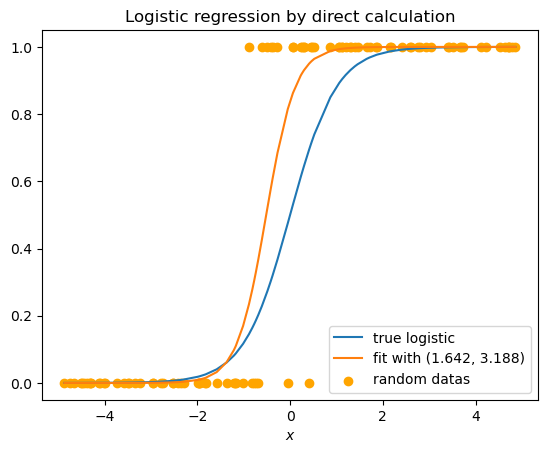

<Figure size 640x480 with 0 Axes>

In [8]:
plt.plot(sorted(x), sorted(p), label="true logistic")
plt.plot(sorted(x), sorted(1/(1+np.exp(-alphas[1]*x-alphas[0]))), label=f"fit with {tuple(alphas)}")
plt.scatter(x, y, color="orange", label="random datas")
plt.title(r"Logistic regression by direct calculation")
plt.xlabel("$x$")
plt.legend()
plt.show()
plt.clf()

Voyons maintenant comment `sklearn` permet de traiter le problème de la régression logistique. Comme d'habitude, on utilise les méthodes `fit` et `predict` pour manipuler le modèle, dont [les paramètres éventuels](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) sont donnés à l'instanciation.

In [9]:
lr = LogisticRegression(penalty='none',random_state=None)
lr.fit(x.reshape(-1,1), y)
alphas = round(lr.intercept_[0], 3), round(lr.coef_[0][0], 3)

pred = lr.predict(x.reshape(-1,1))
predp = lr.predict_proba(x.reshape(-1,1))

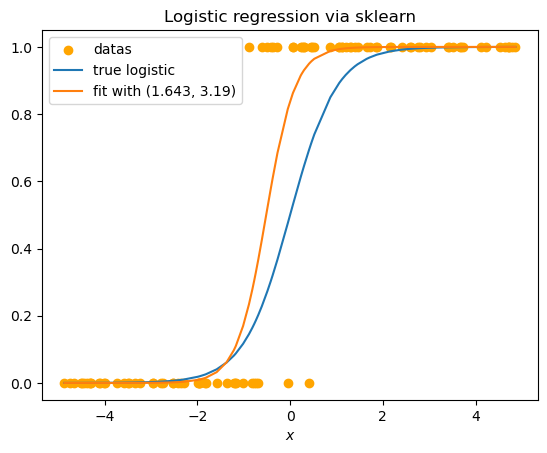

<Figure size 640x480 with 0 Axes>

In [10]:
plt.scatter(x, y, color='orange', label="datas")
plt.plot(sorted(x), sorted(p), label="true logistic")
plt.plot(sorted(x), sorted(predp[:,1]), label=f"fit with {alphas}")
plt.title(r"Logistic regression via sklearn")
plt.xlabel("$x$")
plt.legend()
plt.show()
plt.clf()

##  Forme linéaire générale

Comme on l'a vu dans [le chapitre précédent](linear_regression), un modèle linéaire peut s'écrire, de façon générale

$$
y=\sum_{j=0}^{p}\alpha^{j}x_{j}
$$

et l'algorithme de minimisation du risque permet de calculer les paramètres $\alpha^{j}$. On peut parfaitement généraliser les variables $x_{j}$ au cas de fonctions $\Phi_{j}\left(x\right)$. Mais cela revient uniquement à changer de variable pour les $x_{j}$. Tout le traitement effectué précédemment est identique, en remplaçant simplement les $x_{j}$ par des $\Phi_{j}$.

On peut plutôt chercher à écrire comme modèle une fonction $\Phi$ prenant comme paramètres une représentation linéaire des données, de la forme

$$
y=\Phi\left(\sum_{j=0}^{p}\alpha^{j}x_{j}\right)=\Phi\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)
$$

où la fonction $\Phi$ peut éventuellement être non-linéaire, tant qu'elle est dérivable, on peut appliquer l'algorithme de descente de gradient. Nous avons traité le cas de la régression logistique, pour laquelle la fonction $\Phi$ prend la forme del a fonction logistique. On peut utiliser en réalité n'importe quelle forme de fonction, tant qu'elle est dérivable pour permettre d'appliquer la descente de gradient. Dans les réseaux de neuronnes artificiels, on enchaîne même les fonctions $\Phi$, et on suppose que $y=\Phi_1\left(\Phi_2\left(\cdots\left(\Phi_n\left(\mathbf{X}\cdot\boldsymbol{\alpha}\right)\right)\right)\right)$.


## Conclusion : régressions

Le modèle de la régression linéaire se généralise à tous les modèles d'apprentissage supervisé.

Un modèle d'apprentissage supervisé consiste en 

 - un modèle ($y=\alpha+\beta x$ dans le cadre de la régression linéaire), 
 - un ensemble de données (appelées _features_) $\left\{ x^{i}\right\} _{i\leq N}$, et associées à un un ensemble de résultats (appelés _targets_) $\left\{ y^{i}\right\} _{i\leq N}$
 - une fonction de coût/risque (_risk_ / _cost_ / _loss_ / _metric_ / _score_) que l'on va **optimiser** (minimiser ou maximiser).

Une fois tous ces éléments mis en palce, la procédure est toujors la même : on calcule l'ensemble des paramètres du modèle qui minimisent la fonction de coût sur l'ensemble des données.

Au cours de notre série de note sur la régression, on a pu éxtraire toute une série d'informations ou de pratiques qui sont transversales au traitement des données, à savoir : 

 -  Pour valider un modèle, on tronque le jeu de données en jeu d'entraînement (_train set_) et de test (test set), sur lequel on calcule un score que l'on cherche à optimiser. Cette procédure est appelée _cross-validation_, et est une caractéristique de l'entraînement supervisé et des réseaux de neuronnes artificiels.
 -  Un modèle validé est déterministe : il donne toujours le même résultat (appelé _prediction_) pour une feature donnée. Cela est vrai pour tous les algorithmes optimisés de l'apprentissage machine.
 -  Seule la régression linéaire est exactement solvable. Dans les autres cas, le problème d'optimisation se résout numériquement par une descente de gradient (_gradient descent_). Tous les problèmes de machine learning convergent vers une solution, les réseaux de neuronnes artificiels ne sont pas tous convexes.

Enfin, rappelons que `sci-kit learn` / `sklearn` implémente toujours les méthodes d'apprentissage (`.fit`) et de prédiction (`.predict`) de la même façon. En fait, `sklearn` implémente automatiquement l'algorithme de descente de gradient. `sklearn` prend toujours en entrée la même structure de données.